In [2]:
from arcgis.gis import GIS
from arcgis.apps.itemgraph import ItemGraph, create_dependency_graph
gis = GIS(profile="your_online_profile")

# Troubleshooting Items, Creating Backups, and More

Version 2.4.1 of the ArcGIS API for Python introduces some great new functionality for content management: the `ItemGraph` module and the `OfflineContentManager` module. We'll take a look at what both of these modules are, how they relate to eachother, and how we can use them to enhance our migration workflows.

### `ItemGraph`, `ItemNode`, and `create_dependency_graph()`

We'll start by examining 2 classes and a function that center around a core concept: creating a dependency graph that allows users to examine how items relate to eachother in their ArcGIS Online or Enterprise organizations. These graphs inform us what items are required for other items to exist, and encompass the full range of dependency types for items. 

Before we dive a bit deeper into it, let's briefly go over a handful of the ways an item can be part of another item. There are tons of different item types in the ArcGIS universe, and the ways they all store and use data vary greatly; some are based on JSON structures, some are based on hosted services, and others on a variety of common (or uncommon) file types. Items can use other items in a wide range of ways, such as:
- source files for published layers (e.g., File GDB -> Feature Layer)
- visual components in a web-based app (e.g., a Web Map found in a StoryMap)
- attachments to other items (e.g., a Microsoft Word template in a Survey123 application)

When using the `create_dependency_graph()` function in the Python API, all of these possibilities for item dependencies are taken into account. Users start with a root item (or list of root items), and the function will dig into the data for each one; every item found within them will then also be dug into for dependencies, and so on. All of these items are added to a graph structure (`ItemGraph`) that tracks the relationships between each one. Each one of these items is added to the graph as an `ItemNode`, which has functions allowing users to see which items in the graph an item immediately contains, is immediately contained by, requires to exist, or is required by to exist. Let's take a look.

<Item title:"San Diego Parrot Sightings" type:Form owner:nparavicini_geosaurus>
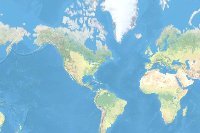

In [2]:
# first, grab a survey to see everything that is required for it to exist
survey_id = "02d0702e1ef0468083f780791670c969"
survey = gis.content.get(survey_id)
survey

In [7]:
graph = create_dependency_graph(gis, [survey])

In [8]:
graph.all_items("item")

[<Item title:"San Diego Parrot Sightings" type:Form owner:nparavicini_geosaurus>,
 <Item title:"San Diego Parrot Sightings_results" type:Feature Layer Collection owner:nparavicini_geosaurus>,
 <Item title:"San Diego Parrot Sightings" type:Feature Layer Collection owner:nparavicini_geosaurus>,
 <Item title:"summary_individual_temp" type:Microsoft Word owner:nparavicini_geosaurus>,
 <Item title:"individual_temp" type:Microsoft Word owner:nparavicini_geosaurus>,
 <Item title:"Topographic" type:Web Map owner:esri_en>,
 <Item title:"summary_temp" type:Microsoft Word owner:nparavicini_geosaurus>,
 <Item title:"San Diego Parrot Sightings_form" type:Feature Layer Collection owner:nparavicini_geosaurus>]

In [10]:
# now, let's grab a node and examine the structure
survey_node = graph.get_node(survey_id)
survey_node

ItemNode(id: 02d0702e1ef0468083f780791670c969, item: San Diego Parrot Sightings)

<Item title:"San Diego Parrot Sightings" type:Form owner:nparavicini_geosaurus>
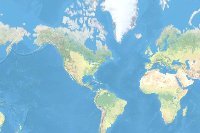

In [11]:
# we can see the item attached to the node if we want
survey_node.item

In [12]:
# we can see everything the survey immediately contains by calling contains()
# we can also change the output format for any of these functions to id or item
survey_node.contains()

[ItemNode(id: a7192e06cfb446e1bab59849285e1038, item: San Diego Parrot Sightings_results),
 ItemNode(id: d818128edbab44099238bc44e4bf2df0, item: summary_individual_temp),
 ItemNode(id: 447ef32f6431488c9f9d7552f7d20ce0, item: individual_temp),
 ItemNode(id: 588f0e0acc514c11bc7c898fed9fc651, item: Topographic),
 ItemNode(id: 6a5d407b62954806ac31558c6774656f, item: summary_temp),
 ItemNode(id: 9fccd6b78482414994eb2c19f90a44c8, item: San Diego Parrot Sightings_form)]

In [13]:
survey_node.contains(out_format = "item")

[<Item title:"San Diego Parrot Sightings_results" type:Feature Layer Collection owner:nparavicini_geosaurus>,
 <Item title:"summary_individual_temp" type:Microsoft Word owner:nparavicini_geosaurus>,
 <Item title:"individual_temp" type:Microsoft Word owner:nparavicini_geosaurus>,
 <Item title:"Topographic" type:Web Map owner:esri_en>,
 <Item title:"summary_temp" type:Microsoft Word owner:nparavicini_geosaurus>,
 <Item title:"San Diego Parrot Sightings_form" type:Feature Layer Collection owner:nparavicini_geosaurus>]

In [14]:
# we can also see the deep dependencies- showing all the items needed by the node to exist
survey_node.requires()

[ItemNode(id: 588f0e0acc514c11bc7c898fed9fc651, item: Topographic),
 ItemNode(id: 447ef32f6431488c9f9d7552f7d20ce0, item: individual_temp),
 ItemNode(id: 6a5d407b62954806ac31558c6774656f, item: summary_temp),
 ItemNode(id: a7192e06cfb446e1bab59849285e1038, item: San Diego Parrot Sightings_results),
 ItemNode(id: d818128edbab44099238bc44e4bf2df0, item: summary_individual_temp),
 ItemNode(id: 9fccd6b78482414994eb2c19f90a44c8, item: San Diego Parrot Sightings_form),
 ItemNode(id: 41dd3cca32914cc7ae8fd3a727f44e17, item: San Diego Parrot Sightings)]

In [15]:
# conversely, we can grab a dependent item and see what items immediately contain it and need it to exist
result_form = graph.get_node("41dd3cca32914cc7ae8fd3a727f44e17")
result_form.item

<Item title:"San Diego Parrot Sightings" type:Feature Layer Collection owner:nparavicini_geosaurus>

In [16]:
result_form.contained_by()

[ItemNode(id: a7192e06cfb446e1bab59849285e1038, item: San Diego Parrot Sightings_results),
 ItemNode(id: 9fccd6b78482414994eb2c19f90a44c8, item: San Diego Parrot Sightings_form)]

In [17]:
result_form.required_by()

[ItemNode(id: 9fccd6b78482414994eb2c19f90a44c8, item: San Diego Parrot Sightings_form),
 ItemNode(id: a7192e06cfb446e1bab59849285e1038, item: San Diego Parrot Sightings_results),
 ItemNode(id: 02d0702e1ef0468083f780791670c969, item: San Diego Parrot Sightings)]

### Automated Troubleshooting with the `ItemGraph` class and `remap_data()` function

Now that we've seen how these things work, let's see how we can use them to speed up what might be an otherwise tedious workflow.

Put yourself in the shoes of an admin that has been tasked with the process of migrating items to a new portal. Before migrating, you want to ensure that all of your items (such as your complex apps) are rendering correctly and not missing any data sources, but don't want to manually click through each one and/or their drafts. How can we more efficiently find out what's missing?

We can create a dependency graph, and then look at which item ID's within the graph don't correspond to existent or accessible items. Let's show a quick example of this by looking at a StoryMap with some broken pieces within it, and show how easy it is to detect and fix it. 

<Item title:"Super High Tech Story" type:StoryMap owner:nparavicini_geosaurus>
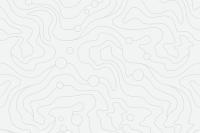

In [3]:
storymap = gis.content.get("fd5801d2f66b43e1a20146d8761f758b")
storymap

In [11]:
# the dependency construction will look for all item id's, but won't retrieve items from broken id's or outside org items
graph2 = create_dependency_graph(gis, [storymap])
graph2.all_items()

[ItemNode(id: fd5801d2f66b43e1a20146d8761f758b, item: Super High Tech Story),
 ItemNode(id: 35983e54e61a40b8ac03148e197452ac, item: PLACES: Arthritis),
 ItemNode(id: 3b7221d4e47740cab9235b839fa55cd7, item: PLACES: Local Data for Better Health),
 ItemNode(id: faa67b0af7914a2f9f4d96c561816c6e),
 ItemNode(id: 7099b3c2e979415e975d00e58afed77e, item: Map that should totally work),
 ItemNode(id: baaf98d1695f47db8d5dc701c0e5f864, item: Read-Only CA/OR Airports),
 ItemNode(id: 0384ujr43n53490890843t543ojf809re)]

In [12]:
# note how some of these items don't have items attached
# that means they're inaccessible in this org or don't exist
# let's find them
for node in graph2.all_items():
    if node.item == None:
        print(node.id)

faa67b0af7914a2f9f4d96c561816c6e
0384ujr43n53490890843t543ojf809re


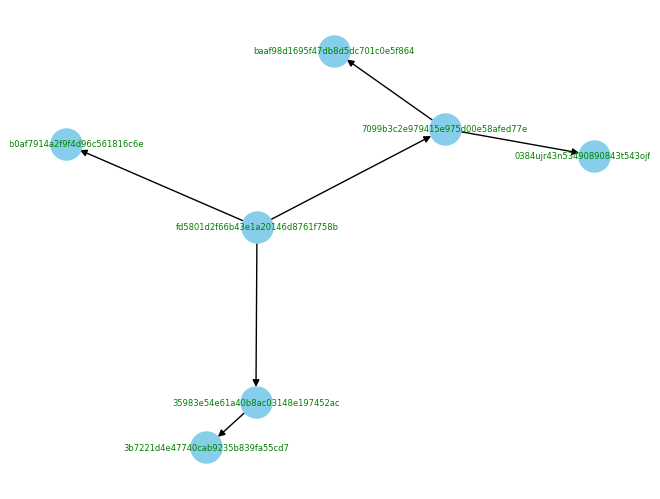

In [21]:
# let's visualize how they fit into the graph to see what we need to fix
# we can do this by employing matplotlib and networkx
import matplotlib.pyplot as plt
import networkx as nx
pos = nx.spring_layout(graph2)  # positions for all nodes
nx.draw(graph2, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=6, font_color="green")
nx.draw_networkx_labels(graph2, pos, labels=nx.get_node_attributes(graph2, 'label'))

# Show the plot
plt.show()

<Item title:"Map that should totally work" type:Web Map owner:nparavicini_geosaurus>
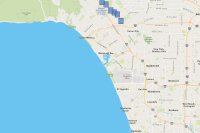

In [7]:
# so we can see that one of them is from our root item, and one is from a dependent item
# let's see what that sub item is
sub_node = graph2.get_node("7099b3c2e979415e975d00e58afed77e")
webmap = sub_node.item
webmap

In [23]:
# now that we know where our two problematic id's exist, we can replace them and fix our storymap
# we can use the item class's remap_data() function to easily do this. let's identify some replacements
bad_layer_id = "0384ujr43n53490890843t543ojf809re"
bad_webmap_id = "faa67b0af7914a2f9f4d96c561816c6e"
new_layer_id = "55c85385338d434ba1194d9b2c2a60c8"
new_webmap_id = "865ec0112fde477788c4f51c4a7baae6"
# we call remap_data() on the item containing the dependencies to be swapped
storymap.remap_data({bad_webmap_id : new_webmap_id}, force = True)
webmap.remap_data({bad_layer_id : new_layer_id}, force = True)

True

In [24]:
# now, we can make a new graph from the storymap and see if everything looks right
graph2_updated = create_dependency_graph(gis, [storymap])
graph2_updated.all_items()

[ItemNode(id: fd5801d2f66b43e1a20146d8761f758b, item: Super High Tech Story),
 ItemNode(id: 35983e54e61a40b8ac03148e197452ac, item: PLACES: Arthritis),
 ItemNode(id: 3b7221d4e47740cab9235b839fa55cd7, item: PLACES: Local Data for Better Health),
 ItemNode(id: 865ec0112fde477788c4f51c4a7baae6, item: clone map different layer id),
 ItemNode(id: 2113d04eade0432784e8edd336193e68, item: CA/OR Airports),
 ItemNode(id: 7099b3c2e979415e975d00e58afed77e, item: Map that should totally work),
 ItemNode(id: baaf98d1695f47db8d5dc701c0e5f864, item: Read-Only CA/OR Airports),
 ItemNode(id: 55c85385338d434ba1194d9b2c2a60c8, item: polygons),
 ItemNode(id: d3a24f71ee864118968fa24e572c6dc2, item: polygons)]

### The `OfflineContentManager` Class and Backups

Now that we've successfully fixed our item(s) that we want to migrate, we're cleared for takeoff. However, what if we want to make sure we have a saved state of this StoryMap and it's dependencies so that we can always restore it in the event that something changes; e.g., an item accidentally gets deleted, or the little hamsters on the wheel that power your company's servers get tired. We can hamster-proof our content by leveraging the also newly added `OfflineContentManager` and its functions.

You can access the module by calling `.offline` on your org's `ContentManager`- we'll show this in a sec. Once you're there, the functions are very straightforward. There's an export function, an import function, and a listing function. The export function will write out a given list of items and all of its dependencies to a compressed file format (a `.contentexport` file)- we'll take a quick look at how that package is structured. 

Once you have that package and want to bring it to a new organization, you can list the items that are found within it, and then subsequently import one or all of them.

The export function is powered behind the scenes by the `ItemGraph` module, so what you see in a given graph for an item (or list of items) is what the export function will attempt to write out. The only addition is that hosted services will be exported to a selected file format. Let's check it out.

In [25]:
source_om = gis.content.offline
export_path = source_om.export_items([storymap])

In [26]:
gis2 = GIS(profile="a_different_profile")
target_om = gis2.content.offline

In [27]:
target_om.list_items(export_path)

{'fd5801d2f66b43e1a20146d8761f758b': {'title': 'Super High Tech Story',
  'type': 'StoryMap',
  'created': 1738011937000,
  'source': 'https://geosaurus.maps.arcgis.com'},
 '7099b3c2e979415e975d00e58afed77e': {'title': 'Map that should totally work',
  'type': 'Web Map',
  'created': 1738011538000,
  'source': 'https://geosaurus.maps.arcgis.com'},
 'baaf98d1695f47db8d5dc701c0e5f864': {'title': 'Read-Only CA/OR Airports',
  'type': 'Feature Service',
  'created': 1687549320000,
  'source': 'https://geosaurus.maps.arcgis.com'},
 '55c85385338d434ba1194d9b2c2a60c8': {'title': 'polygons',
  'type': 'Feature Service',
  'created': 1700601469000,
  'source': 'https://geosaurus.maps.arcgis.com'},
 'd3a24f71ee864118968fa24e572c6dc2': {'title': 'polygons',
  'type': 'Shapefile',
  'created': 1700601426000,
  'source': 'https://geosaurus.maps.arcgis.com'},
 '865ec0112fde477788c4f51c4a7baae6': {'title': 'clone map different layer id',
  'type': 'Web Map',
  'created': 1725896776000,
  'source': 'h

In [ ]:
target_om.import_content(export_path, folder = "dev_summit")